In [1]:
!pip install yfinance
!pip install ta
!pip install tqdm

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import ta

# Introduction
Engaging in trend-following doesn't revolve around timing specific markets based on trends. Nowadays, professional trend-followers often participate in trading numerous futures markets spanning equities, bonds, currencies, commodities, and even more unconventional markets like carbon offsets.

Why diversification?
In 1964, Bill Sharpe published a treatise titled "Capital Asset Prices: A Theory of Market Equilibrium under Conditions of Risk," outlining a method for investors to attain higher returns while maintaining diversification. Investors willing to embrace higher risk in their pursuit of better returns would leverage their investments to acquire more units of this diversified portfolio. This approach is more favorable than venturing beyond the efficient frontier into portfolios heavily concentrated in single stocks.

Sharpe+Leverage is the key
Using a prudent level of leverage to allocate capital into the portfolio with the highest Sharpe ratio, an investor can exploit opportunities in various market conditions and across different economic regions. In contrast, an investor with a concentrated approach may anticipate favorable returns solely during prolonged periods of economic expansion. Under reasonable assumptions regarding the relationship between risk and return, a diversified portfolio will generate significantly higher returns per unit of risk.

# Download data and perform portfolio backtest

In [2]:
def get_data(ticker, start_date, end_date):
    """
    Download historical candlestick data from yfinance database.
    
    :return:
    """    
    # Download data from Yahoo Finance
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    
    # Create columns of interest for the backtest
    data['next_day_return'] = data['Adj Close'].shift(-1) / data['Adj Close']
    
    # Drop nan values
    data.dropna(inplace=True)
    
    return data

In [24]:
tickers = ['XLK', 'XLV', 'XLF', 'XLY', 'XLP', 'XLE', 'XLB', 'XLI', 'XLU']
start_date = '2000-01-01'
end_date = '2024-01-01'

########################################################################################################
# Download historical data of every ticker
########################################################################################################
print('\nDownload data...')
dfs = {}
for ticker in tickers:
    data = get_data(ticker, start_date, end_date)
    dfs[ticker] = data

########################################################################################################
# Set same dates for all the datasets
########################################################################################################
dates = dfs[tickers[0]].index
for ticker in tickers[1:]:
    dfs[ticker] = dfs[ticker].reindex(dates).interpolate(method='time').dropna()
    
max_start_date = max([df.index.min() for df in dfs.values()])
min_end_date = min([df.index.max() for df in dfs.values()])

for ticker in tickers:
    dfs[ticker] = dfs[ticker][max_start_date:min_end_date]

########################################################################################################
# Calculation of signals
########################################################################################################
print('\nCalculation of signals for every asset...')
for ticker in tqdm(tickers):
    # ----------------------------------------------------------------------------------------------
    data = dfs[ticker].copy()
    data['Close'] = data['Adj Close']
    
    # ----------------------------------------------------------------------------------------------
    # Short, Mid and Long Moving Averages
    data['short_ema'] = data.Close.ewm(span=20, adjust=False).mean()
    data['mid_ema'] = data.Close.ewm(span=100, adjust=False).mean()
    data['long_ema'] = data.Close.ewm(span=500, adjust=False).mean()

    # ----------------------------------------------------------------------------------------------
    # Relative Strength Indicator
    data['short_rsi'] = ta.momentum.RSIIndicator(data['Close'], window=5).rsi()
    data['long_rsi'] = ta.momentum.RSIIndicator(data['Close'], window=30).rsi()

    # ----------------------------------------------------------------------------------------------
    # Average True Range, as volatility indicator
    high_low = data['High'] - data['Low']
    high_close = abs(data['High'] - data['Close'].shift())
    low_close = abs(data['Low'] - data['Close'].shift())
    TR = pd.DataFrame({'hl':high_low, 'hc':high_close, 'lc':low_close}).max(axis=1) / data.Close
    data['short_atr'] = TR.rolling(window=25).mean()
    data['long_atr'] = TR.rolling(window=200).mean()
    
    # ----------------------------------------------------------------------------------------------
    # 1y CAGR volatility
    data['annualized_return'] = data['Close'].pct_change(periods=252)
    data['volatility'] = data['annualized_return'].rolling(window=252).std()

    # ----------------------------------------------------------------------------------------------
    # Drop nan values
    data.dropna(inplace=True)

    # ----------------------------------------------------------------------------------------------
    # Signals
    data['signal_1'] = (data['short_ema'] > data['mid_ema']) & (data['mid_ema'] > data['long_ema'])
    data['signal_2'] = (data['long_rsi'] > 30) & (data['long_rsi'] < 70) & (data['short_rsi'] > data['long_rsi'])
    data['signal_3'] = data['short_atr'] < data['long_atr']
    data['entry_signal'] = data['signal_1'] & data['signal_2'] & data['signal_3']
    data['exit_signal'] = (data['Close'] < data['long_ema'])
    
    # ----------------------------------------------------------------------------------------------
    # Generate de True/False signal: True if we hold the asset, False if we stay in cash
    signal = []
    invested = False
    for cont, (i, row) in enumerate(data.iterrows()):
        if not invested:
            # If we stay in cash, we wait for Entry signal
            if row['entry_signal']:
                invested = True
                signal.append(True)
                invest_t = cont
            else:
                signal.append(False)
        elif invested:
            # If we hold the asset, we wait for Exit signal
            if row['exit_signal']:    
                invested = False
                signal.append(False)
            else:
                signal.append(True)

    data['signal'] = signal
    dfs[ticker] = data.copy()

########################################################################################################
# Backtest of the portfolio
########################################################################################################
print('\nPortfolio backtest...')
strategy_returns = []
weights_history = []
for cont in tqdm(range(len(dfs[tickers[0]]))):
    weights = {}
    for ticker in tickers:
        # Weight of every asset is calculted as inverse of volatility
        if dfs[ticker].iloc[cont]['signal']:
            weights[ticker] = 1 / dfs[ticker].iloc[cont]['volatility']
        else:
            weights[ticker] = 0.
            
    weights_history.append(weights)
    
    # Total weight is used to normalized weights
    total_weight = sum([weight for weight in weights.values()])
    
    # If we stay in cash...
    if total_weight == 0.:
        strategy_returns.append(1.)
        continue
    
    # Calculate strategy return, as weighted sum of assets' returns
    strategy_return = 0.
    for ticker in weights.keys():
        weight = weights[ticker] / total_weight
        strategy_return += (dfs[ticker].iloc[cont]['next_day_return'] - 1) * weight
    
    strategy_returns.append(strategy_return + 1)


Download data...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Calculation of signals for every asset...


  0%|          | 0/9 [00:00<?, ?it/s]


Portfolio backtest...


  0%|          | 0/5533 [00:00<?, ?it/s]

# Calculate some metrics of interest

In [25]:
invested_capital = 100_000
equity_curve = np.cumprod(strategy_returns) * invested_capital

# New DataFrame with results from the backtest
results = pd.DataFrame({'equity_curve': equity_curve})
results.index = dfs[tickers[0]].index
results['annualized_return'] = results['equity_curve'].pct_change(periods=252)

# 1y CAGR volatility
volatility = results['annualized_return'].std()

# Maximum drawdown
results['drawdown'] = (1 - results['equity_curve'] / results['equity_curve'].cummax())
max_drawdown = results['drawdown'].max()

# Compound Annual Return
risk_free_rate = 0.01
final_capital = results['equity_curve'].values[-1]
N_years = (results.index.max() - results.index.min()).days / 365
compound_annual_return = ((final_capital / invested_capital) ** (1 / N_years) - 1)

# Best and worst 1y return
best_year = results['annualized_return'].max()
worst_year = results['annualized_return'].min()

# Sharpe ratio
sharpe_ratio = (results['annualized_return'] - risk_free_rate).mean() / volatility

# Sortino retio
negative_returns = results[results['annualized_return'] < risk_free_rate]['annualized_return']
sortino_ratio = results['annualized_return'].mean() / negative_returns.std()

# DataFrame with weights of every asset in the portfolio
weights = pd.DataFrame(weights_history)
weights.index = results.index
row_sums = weights.sum(axis=1)
weights = weights.div(row_sums, axis=0) * 100
weights.fillna(0., inplace=True)

In [26]:
print('PORTFOLIO TREND-FOLLOWING STRATEGY')
print('-------------------------------------------')
descriptions = [
    'Invested Capital: ',
    'Final Capital: ',
    'Compound Annual Return: ',
    'Best Year Return: ',
    'Worst Year Return: ',
    'Max Drawdown: ',
    'Volatility: ',
    'Sharpe Ratio: ',
    'Sortino Ratio: '
]
values = [
    100,
    final_capital/1e3,
    100*compound_annual_return,
    100*best_year,
    100*worst_year,
    100*max_drawdown,
    100*volatility,
    sharpe_ratio,
    sortino_ratio
]
units = [
    'k$',
    'k$',
    '%',
    '%',
    '%',
    '%',
    '%',
    '',
    ''
]
max_length = max(len(description) for description in descriptions)
for description, value, unit in zip(descriptions, values, units):
    print(f'{description.ljust(max_length)} {value:.2f}{unit}')

print('')
for ticker in tickers:
    value = weights[ticker].mean()
    description = f'{ticker} mean weight: '
    unit = '%'
    print(f'{description.ljust(max_length)} {value:.2f}{unit}')

PORTFOLIO TREND-FOLLOWING STRATEGY
-------------------------------------------
Invested Capital:        100.00k$
Final Capital:           629.10k$
Compound Annual Return:  8.72%
Best Year Return:        45.14%
Worst Year Return:       -16.11%
Max Drawdown:            24.64%
Volatility:              10.21%
Sharpe Ratio:            0.85
Sortino Ratio:           2.12

XLK mean weight:         8.16%
XLV mean weight:         12.97%
XLF mean weight:         6.76%
XLY mean weight:         9.65%
XLP mean weight:         18.61%
XLE mean weight:         5.48%
XLB mean weight:         8.75%
XLI mean weight:         8.64%
XLU mean weight:         11.74%


# Plot some results

<IPython.core.display.Javascript object>


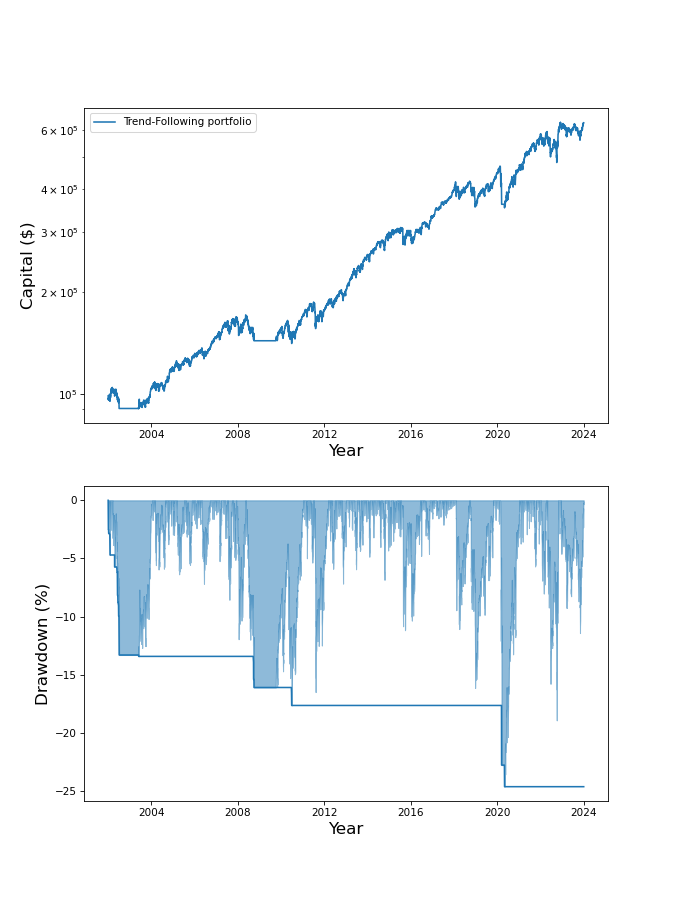

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12))

# -------------------------------------------------------------------------------------
ax1.plot(pd.to_datetime(results.index), results.equity_curve, label='Trend-Following portfolio')
ax1.set_yscale('log')
ax1.legend()

ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Capital ($)', fontsize=16)

# -------------------------------------------------------------------------------------
ax2.fill_between(pd.to_datetime(results.index), -100*results.drawdown, color='C0', alpha=0.5)
ax2.plot(pd.to_datetime(results.index), -100*results.drawdown.cummax(), color='C0')

ax2.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Drawdown (%)', fontsize=16)

plt.savefig('trend_following_portfolio.png')

<IPython.core.display.Javascript object>


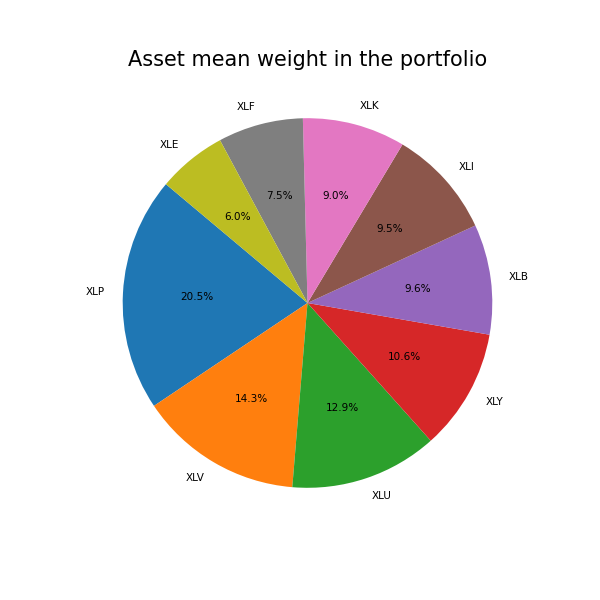

In [28]:
mean_weights = {}
for ticker in tickers:
    mean_weights[ticker] = weights[ticker].mean()

mean_weights = {k: v for k, v in sorted(mean_weights.items(), key=lambda item: item[1], reverse=True)}
categories = list(mean_weights.keys())
percentages = list(mean_weights.values())
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(percentages, labels=categories, autopct='%1.1f%%', startangle=140)
ax.set_title('Asset mean weight in the portfolio', fontsize=20)
plt.savefig('portfolio_mean_weights.png')

<IPython.core.display.Javascript object>


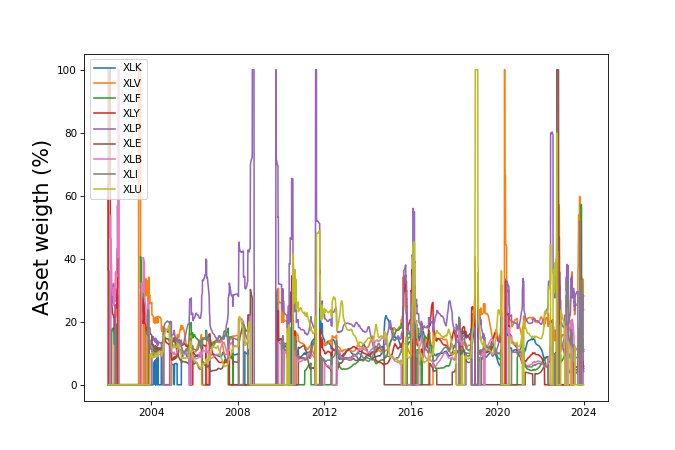

Text(0, 0.5, 'Asset weigth (%)')

In [29]:
fig, ax = plt.subplots(figsize=(9, 6))

for ticker in tickers:
    ax.plot(pd.to_datetime(weights.index), weights[ticker], label=ticker)
ax.legend(loc='upper left')
ax.set_ylabel('Asset weigth (%)', fontsize=20)